In [1]:
#Importing the things
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
from pylab import *
import scipy.ndimage as ndi
import scipy
import seaborn as sns
import copy

"""
Next steps
1) Developmental changes
    - 3 epochs = embryonic period of just ASSN act, then let LOT be plastic, then LOT fixed
    - Change in activation function (memb exc) over dev
    - GABA-E -> GABA-I switch
2) SL cells serving different roles in different times (first as quick learner, then as noise introduction)
    - eventually make all the classes (SL, SP, DP, FFI, FBI)
    - add in some reward signal (that goes with certain odors, and increases plasticity or something)
3) Timing (recurrence between time steps, different delays to activation [delay inh activation -> two peaks], etc)
    - *add in temporal directionality of LTP/LTD
        - option 1) if neuron i fires in response to LOT, then it fired BEFORE a neuron j that only fired due to ASSN
        - option 2) make ASSN based on previous time step!!!
4) Read Hopfield
    - see if I can get integration/short term memory of odor-driven ASSN even after odor stops
    - initialize a matrix M = xi*xi^T, where the states xi_i are +/-1
5) Change from binary units to firing rate
     - make neurons non-linear with ReLU, then use some correlation between two matrices to do LTP/LTD (can apply asymmetry, so if A is high but B is low, then W_B,A is LTD and W_A,B is LTP)
"""

'\nNext steps\n1) Developmental changes\n    - 3 epochs = embryonic period of just ASSN act, then let LOT be plastic, then LOT fixed\n    - Change in activation function (memb exc) over dev\n    - GABA-E -> GABA-I switch\n2) SL cells serving different roles in different times (first as quick learner, then as noise introduction)\n    - eventually make all the classes (SL, SP, DP, FFI, FBI)\n    - add in some reward signal (that goes with certain odors, and increases plasticity or something)\n3) Timing (recurrence between time steps, different delays to activation [delay inh activation -> two peaks], etc)\n    - *add in temporal directionality of LTP/LTD\n        - option 1) if neuron i fires in response to LOT, then it fired BEFORE a neuron j that only fired due to ASSN\n        - option 2) make ASSN based on previous time step!!!\n4) Read Hopfield\n    - see if I can get integration/short term memory of odor-driven ASSN even after odor stops\n    - initialize a matrix M = xi*xi^T, wher

LOT Weights


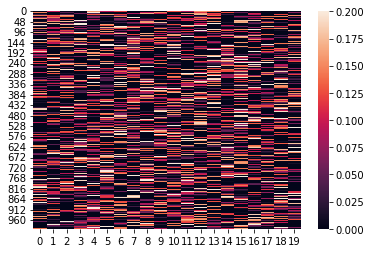

ASSN Weights


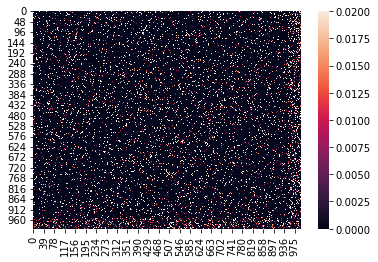

Inh Weights


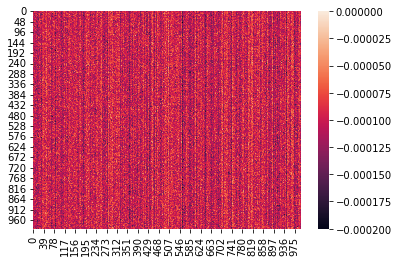

In [2]:
#Initialize activity vector (v), LOT matrix (M), and ASSN matrix (W)

n = 1000 #number of Pir neurons
glom = int(n / 50) #make LOT inputs some % of total ASSN units

#Create vector 'v' of 'n' neurons with initial firing rates r = 0
v = [0] * n

##############################################################################################################################
#Create random LOT weight matrix 'M', given n/10 odors, drawn from uniform distribution to increase spread between LOT weights
M = np.random.rand(n,glom);

#Sparsify and normalize LOT 'M'
for i in range(len(M)): #loop over all rows of W
    
    shuffled_M = array(range(glom));
    np.random.shuffle(shuffled_M); #create a shuffled array of indices in each row to set to 0

    for j in range(int(len(shuffled_M)*0.5)): #loop over 50% of the shuffled array

        M[i,shuffled_M[j]] = 0 #set 50% of elements in W to 0
    
    #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
    row_sum = np.sum(M[i,:]);
    M[i,:] = M[i,:]/row_sum;

##############################################################################################################################
#Create random ASSN weight matrix 'W' (this is drawn from 0-mean Normal distribution, to make it so ASSN weights start low with some inhibitory ASSN to start with)
#W = (np.random.normal(0, 55, size=(n,n))); #sigma here doesn't matter since we are normalizing later; making it large makes it less likely for us to start with a weight of 0
W = np.random.rand(n,n);
hub_ind = 0.95; #percentage of cells that are not hub neurons
hub_conn = 0.75; #connectivity of hub neurons

#Sparsify and normalize ASSN 'W'
for i in range(len(W)): #loop over all rows of W except the last 10% which will be hub neurons
    
    if i < len(W)*hub_ind: #only apply this sparsification for the non-hub neurons
        
        #Sparsify inputs from non-hub cells to 10%
        shuffled_W = array(range(int(n*hub_ind))); #shuffles index of all except hub neurons (so hub neurons won't get their inputs to these neurons set to 0)
        np.random.shuffle(shuffled_W); #create a shuffled array of indices in each row to set to 0

        for j in range(int(len(shuffled_W)*0.9)): #loop over 90% of the shuffled array

            W[i,shuffled_W[j]] = 0 #set 90% of elements in W to 0
            
        #Sparsify inputs from hub cells to hub_conn%
        shuffled_W = array(range(int(n*hub_ind),n)); #shuffles index of all except hub neurons (so hub neurons won't get their inputs to these neurons set to 0)
        np.random.shuffle(shuffled_W); #create a shuffled array of indices in each row to set to 0

        for j in range(int(len(shuffled_W)*hub_conn)): #loop over 80% of the shuffled array

            W[i,shuffled_W[j]] = 0 #set hub_conn% of elements in W to 0

        #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
        #row_sum = np.sum(W[i,:]);
        SLSP_scale_factor = 2; #some factor to scale the SL-SP ASSN weights (right now set so weights are 0.02 after normalization)
        temprow = W[i,:];
        temprow_nonzero = temprow[temprow != 0]; #create a vector of just the non-zero entries in that row
        W[i,:] = W[i,:]/np.sum(temprow_nonzero)*SLSP_scale_factor; #we normalize by the sum of just the non-zero entries bc the 0 entries are numerically not 0 or something? and it's fucking up the row sum

    else: #hub neurons, the last 10% of units;
        
        #Sparsify inputs from all cells to hub cells 
        shuffled_W = array(range(n));
        np.random.shuffle(shuffled_W); #create a shuffled array of indices in each row to set to 0

        for j in range(int(len(shuffled_W)*hub_conn)): #loop over hub_conn% of the shuffled array

            W[i,shuffled_W[j]] = 0 #set hub_conn% of elements in W to 0
        
        hub_scale_factor = 3; #since these neurons have 10x more connections, need to scale up 10x so the normalization doesn't reduce each weight to 10% of normal
        temprow = W[i,:];
        temprow_nonzero = temprow[temprow != 0]; #create a vector of just the non-zero entries in that row
        W[i,:] = W[i,:]/np.sum(temprow_nonzero)*hub_scale_factor; #we normalize by the sum of just the non-zero entries bc the 0 entries are numerically not 0 or something? and it's fucking up the row sum

##############################################################################################################################
#Define input matrix from ASSN exc -> feedback inhibitory neurons
input_weight = 0.5; #set some weight from exc -> inh
FBIin = np.random.rand(100,n);

#Sparsify and normalize FBIin
for i in range(len(FBIin)): #loop over all rows of FBI
    
    shuffled_FBIin = array(range(n));
    np.random.shuffle(shuffled_FBIin); #create a shuffled array of indices in each row to set to 0

    for j in range(int(len(shuffled_FBIin)*0.5)): #loop over 50% of the shuffled array

        FBIin[i,shuffled_FBIin[j]] = 0 #set 50% of elements in W to 0
    
    #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
    row_sum = np.sum(FBIin[i,:]);
    FBIin[i,:] = FBIin[i,:]/(row_sum)*input_weight;

#Define output matrix from feedback inhibitory neurons -> ASSN exc
output_weight = -0.2; #set some inhibitory weight
FBIout = np.random.rand(n,100);

#Sparsify and normalize FBIin
for i in range(len(FBIout)): #loop over all rows of FBI
    
    shuffled_FBIout = array(range(100));
    np.random.shuffle(shuffled_FBIout); #create a shuffled array of indices in each row to set to 0

    for j in range(int(len(shuffled_FBIout)*0.5)): #loop over 50% of the shuffled array

        FBIout[i,shuffled_FBIout[j]] = 0 #set 50% of elements in W to 0
    
    #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
    row_sum = np.sum(FBIout[i,:]);
    FBIout[i,:] = FBIout[i,:]/(row_sum)*output_weight;

FBI = np.matmul(FBIout,FBIin);
    
##############################################################################################################################      
#Print weight matrices heatmaps for viewing    
print("LOT Weights")
ax = sns.heatmap(M, vmin = -0, vmax = 0.2)
plt.show()

print("ASSN Weights")
ax = sns.heatmap(W, vmin = 0, vmax = 0.02)
plt.show()

print("Inh Weights")
ax = sns.heatmap(FBI, vmin = -0.0002, vmax = 0.0) #weights here will be small since the connectivity is denser for FBI
plt.show()

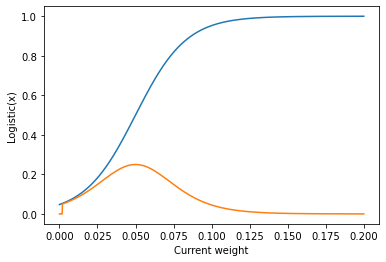

In [7]:
#Create learning rate function for returning LTP/LTD rate as the derivative of a logistic function of current synaptic weight
    #note = logistic is the just the general form of a sigmoidal function
    #derivative of logistic function = since I want to weight increase/decrease to look sigmoidal, I want the LTP/LTD rate to actually be the derivative of a sigmoidal
        #note = since derivative of logistic function is symmetric, I can use the same for LTP and LTD

"""
Think about how to incorporate silent synapses
"""

#Manually define the components of the piece-wise logistic function
x = np.linspace(0,20,1000); #max weight is now 20 / 100 = 0.2
z = 1/(1 + np.exp(0.6*(-x+5))); #the 0.08 here is by default 1, but that would make the slope really sharp; smaller numbers give rounder functions; +25 is a right-shift of the mid-point of the curve

#Take the derivative of the logistic function
dz = z*(1-z); #can write out the dz/dx and use chain rule to prove this equation is true
dz[0:10] = 0; #cap dz for upper end so we don't decrease to negative
dz[900:1000] = 0; #cap dz for upper end ASSN weights, so you won't increase past an ASSN weight of +/-0.2
    #problem with this is that weights will get stuck at > +/- 0.95 since they can't change anymore after they get here...

def sig(w): #Takes in a weight 'w', returns an LTP/LTD rate 'r'
    
    eps = 0.2 #epsilon learning rate

    #On the off-chance that a weight is greater than 0.2, force it to be 0.19 so it can index properly into dz
    if w > 0.2:
        w = 0.19;
        
    r = eps*dz[int(np.absolute(w*100))]; #take the current weight, multiply by 200 (since the code for the logistic function doesn't seem to like 0-1 decimals), cast as int to use as index in dz[]; use np.absolute to include the negative ASSN weights

    return r

#Visualize z (blue) and dz (orange)
plt.plot(x/100, z)
plt.plot(x/100, dz) #need to plot separately or else it won't do dz as a function of x, it'll just plot dz vs its indices
plt.xlabel("Current weight")
plt.ylabel("Logistic(x)")
plt.show()

Odor trials


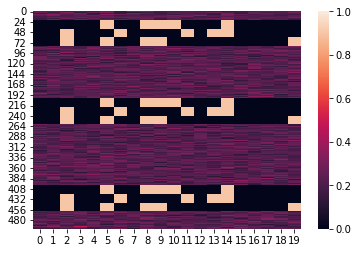

In [9]:
#Generate a time-variant odor series, with periods of odor input and spont act during rest period

#Define number of time steps for trial
t_range = 500;

#Create odor input time series
"""
odor = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor[odor < 0] = 0; #remove negative values for odor

odor1 = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor1[odor1 < 0] = 0; #remove negative values for odor

odor2 = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor2[odor2 < 0] = 0; #remove negative values for odor
"""

#Create odor blocks that are more clearly defined rather than graded
mag = 0.9 #magnitude of input to LOT weights

odor = np.zeros(glom)
shuffled = array(range(glom)) 
np.random.shuffle(shuffled) #create a random permutation of 1:glom

for i in range(int(len(shuffled)/4)): #sparsify odor by making activating 1/4 of gloms
    odor[shuffled[i]] = mag
    
odor1 = np.zeros(glom)
shuffled = array(range(glom))
np.random.shuffle(shuffled)
for i in range(int(len(shuffled)/4)):
    odor1[shuffled[i]] = mag
    
odor2 = np.zeros(glom)
shuffled = array(range(glom))
np.random.shuffle(shuffled)
for i in range(int(len(shuffled)/4)):
    odor2[shuffled[i]] = mag

#bg spont act drawn from Poisson with mean intensity as odor
odor_total = [odor,odor1,odor2];
u = np.random.poisson(lam=mean(odor_total)*100,size=(t_range,glom))/100 

#Create blocks of odor for 500 trials
u[20:40,:] = odor
u[40:60,:] = odor1
u[60:80,:] = odor2
u[200:220,:] = odor
u[220:240,:] = odor1
u[240:260,:] = odor2
u[400:420,:] = odor
u[420:440,:] = odor1
u[440:460,:] = odor2
u[620:640,:] = odor
u[640:660,:] = odor1
u[660:680,:] = odor2
u[820:840,:] = odor
u[840:860,:] = odor1
u[860:880,:] = odor2

#Print odor time series heatmap
print("Odor trials")
ax = sns.heatmap(u, vmin = 0, vmax = 1)
plt.show()

In [10]:
#Loop activity over time, updating the weights in act-dep fashion
FBIout_new = np.zeros(shape(FBIout));
FBIout_new[:] = FBIout[:];

#Construct new W_new to update weights without affecting the initial matrix (using W[:] copies all values, but doesn't pass the list by reference, ie. doesn't equate W_new and W such that W itself gets updated over iterations)
W_new = np.zeros(shape(W));
W_new[:] = W[:];

#Construct a matrix that has 1's where the are non-zero elements, and 0's where there are 0 elements; this way I don't have to loop through all elements later
W_ones = np.zeros(shape(W));
W_ones[:] = W[:];
W_ones[W_ones != 0] = 1;
num_inputs = int(hub_ind*100+(1-hub_ind)*(1-hub_conn)*1000)+1; #calculate total number of inputs assuming 10% connectivity among non-hub and 50% connectivity from/to hub; +1 just fixes some stupid indexing error
W_nonzeros = np.zeros((n,num_inputs)); #for getting indices of all non-zero elements later in the loop

#Instantiate matrices for storing neti/activity over loop for printing later
neti_list = [];
v_list = [];

#Define bias weights (for now this is mainly to make hub neurons more hyperpol)
b = np.zeros(n);
b[int(hub_ind*n):n] = np.random.uniform(-0.3,-0.1,size=int((1-hub_ind)*n)); #add a -0.6 to -0.8 bias weight for hub neurons (empirically determined to make things look nice)

###############################################################################################
#Iterate over many time steps while updating weights

#Set threshold of "activity" for being counted as a "spike" or active during that trial
thres = 0.65;

for t in range(t_range):
           
    #Calculate input from LOT at time t
    u_lot = M.dot(u[t,:]);

    #Calculate input from ASSN following LOT-driven activity
    u_assn = W_new.dot(u_lot);
    """
    Consider thresholding before this, so everything is more binary; should then do this with inh too
    """
    
    #Sum input from LOT and ASSN, store in net input neti_list matrix
    neti = u_lot + u_assn; #for testing LOT + ASSN
    #neti = u_lot; #for testing LOT only 
        
    #Calculate feedback inhibition, and incorporate bias weights of hub neurons
    FBI = np.matmul(FBIout_new,FBIin);
    u_fbi = FBI.dot(neti)
    neti = neti + u_fbi + b;
    neti_list.append(copy.deepcopy(neti));
    #print("neti",neti)
    
    """    
    #Compute activation given net input, store in activation a_list matrix
    a = act(neti);
    a_list.append(copy.deepcopy(act(neti))) #deepcopy here is necessary bc append usually creates a shallow reference to 'a'; in the next time step when we update 'a', it will also update the previous timestep's reference of 'a' in the list
    #print("a",a)
    
    #Threshold a() via ReLU
    a[a < 0.2] = 0;
    a[a > 0.2] -= 0.2;
    
    #Increase weight as a 
    #for i in range(len(v)):
    """       
    
    #Binarize v into firing (1) or not firing (0), add to the v_list matrix
    v = np.zeros(n);
    v[:] = neti[:];
    v[v < thres] = 0;
    v[v >= thres] = 1;
    
    #Add stochasticity to spiking, such that 25% of units passing threshold don't spike
    v_rand = v*np.random.rand(len(v));
    v_rand[v_rand <= 0.25] = 0;
    v_rand[v_rand > 0.25] = 1;
    v[:] = v_rand[:];
    v_list.append(v) #append activity vector as a row to the activity matrix v_list
    #print("v",v)
    
    """
    #Run spont act in Pir layer on some trials (simulate spontaneous network bursts)
    spontrange = [16,17,18,19];
    
    if (t % 20) == 15: #for every 10 trials, have a network burst of 3 trials; this sets the network burst ensemble
        v = np.zeros(n);
        v = np.random.binomial(1,0.1,n); #creates a random array where 10% of the neurons have activity = 1
        v_list.append(v);
        
    elif (t % 20) in spontrange:
        
        v_list.append(v); #this just keeps the same v from the previous trial
        
    else: #for other trials, get v from LOT + ASSN as usual
        
        v = np.zeros(n);
        v[:] = neti[:];
        v[v < thres] = 0;
        v[v >= thres] = 1;
        v_list.append(v) #append activity vector as a row to the activity matrix v_list
        
    """
    
    #Loop through all neurons and update weights
    for i in range(len(v)):
             
        if i < n*hub_ind: #for non-hub neurons, only loop through the 10% of other neurons that give it input
            
            #Construct matrix of indices where input weights != 0, so for Hebbian we are only looping through units that have connections to the i-th unit
            if t == 0: #only do this matrix on the first loop, since it won't change
        
                inputs = W_ones[i,:]; #get all inputs to neuron i from W_ones
                searchval = 1.0; 
                W_nonzeros[i,:]  = np.where(inputs == searchval)[0]; #search for all elements == 1, then store that to the W_nonzeros matrix
   
            #Apply Hebbian learning between excitatory cells
            #If neuron j is not firing
            if v[i] == 0:

                #Loop through all other neurons that have inputs to the i-th neuron
                for j in W_nonzeros[i,:].astype(int): #convert matrix row to int, otherwise you can't index; with 

                    #If neuron k is firing (and k != j, so we don't update autapses)
                    if v[j] == 1 and i != j and W_new[i,j] != 0 and (np.random.rand() > 0.25): #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes

                        #Decrease the weight by dz (see sig() above) in order to create logistic growth of ASSN weight
                        W_new[i,j] -= 0.5*sig(W_new[i,j]); #scale by 0.2 so we don't get runaway inh weights from attractor cells to inhibit all other cells

            #If neuron j is firing
            elif v[i] == 1:

                #Loop through all other neurons that have inputs to the i-th neuron
                for j in W_nonzeros[i,:].astype(int): #convert matrix row to int, otherwise you can't index

                    #If neuron k is firing (and k != j, so we don't update autapses)
                    if v[j] == 1 and i != j and W_new[i,j] != 0 and (np.random.rand() > 0.25): #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes

                        #Increase the weight by dz (see sig() above) in order to create logistic decay of ASSN weight
                        W_new[i,j] += sig(W_new[i,j]); 
        
        else: #loop  through all neurons, since most will have inputs to hub neurons
            #If neuron j is not firing
            if v[i] == 0:

                #loop over all other neurons
                for j in range(len(v)):

                    #If neuron k is firing (and k != j, so we don't update autapses)
                    if v[j] == 1 and i != j and W_new[i,j] != 0 and (np.random.rand() > 0.25): #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes

                        #Decrease the weight by dz (see sig() above) in order to create logistic growth of ASSN weight
                        W_new[i,j] -= 0.5*sig(W_new[i,j]); #scale by 0.5 so we don't drop out connections too quickly

            #If neuron j is firing
            elif v[i] == 1:

                #loop over all other neurons
                for j in range(len(v)):

                    #If neuron k is firing (and k != j, so we don't update autapses)
                    if v[j] == 1 and i != j and W_new[i,j] != 0 and (np.random.rand() > 0.25): #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes

                        #Increase the weight by dz (see sig() above) in order to create logistic decay of ASSN weight
                        W_new[i,j] += sig(W_new[i,j]); 
    
    #Every 5 time steps, introduce noise to exc weight matrix
    if t % 5 == 0:
        
        weight_noise = 0.2 #this iteration of weight_noise is to make the noise scale by a factor of weight_noise wrt to the current synaptic weight (this punishes attractor units more); can't be too high or else some weight fluctuations will go wild
        #note = don't make this too high or else you risk jumping out of the weight boundaries and slipping into attractors
        
        #Generate a noise matrix of random +/-weight_noise, only at the non-zero elements of the weight matrix
        noise_mat = np.random.binomial(1,0.5,size=(n,n));
        noise_mat[noise_mat == 0] = -1;
        noise_mat = np.multiply(noise_mat,W_ones)*weight_noise; #this does unitwise multiplication of a random noise_mat matrix with W_ones to make all the 0-weight elements 0, then scales the remaining elements by weight_noise
        noise_mat = np.multiply(noise_mat,W_new); #this does unitwise multiplication of noise_mat by W_new, to generate a matrix where the noise is proportional to the synaptic weight
        
        #Add noise matrix to weight matrix
        W_new += noise_mat
        
    #Every 20 time steps, update FBI weights based on increase in ASSN weights
    if t % 20 == 0:
        
        new_rowmeans = np.mean(W_new,axis=1); #calculate means of inputs onto each unit (row means of W)
        
        if t > 0:
            rowmean_diff = new_rowmeans - old_rowmeans; #calculate  change in mean of weights onto each unit
            rowmean_diff[rowmean_diff < 0] = 0 #only deal with weights that have increased, such that you aren't decreasing inh on units that have decreased exc
            inh_scale = 150; #some amount to scale the rowmean_diff when calculating how much to increase FBIout_new rows (for now this is empirically determined, to keep firing sparse)
            row_change = np.ones(len(rowmean_diff)) + inh_scale*rowmean_diff; #do 1 + rowmean_diff, to get the desired fold change in the weights
            FBIout_temp = np.transpose(FBIout_new); #the next three lines are stupid transpose shit so we can multiply the rows of FBIout_new by the elements of row_change, since python can't do linear algebra
            FBIout_temp = row_change*FBIout_temp;
            FBIout_new = np.transpose(FBIout_temp);
        
        old_rowmeans = np.zeros(len(new_rowmeans)); #store new_rowmeans as old_rowmeans for next iteration
        old_rowmeans[:] = new_rowmeans[:];   
    
    """
    #Export time series of heatmaps every 10 time steps
    plt.imshow(W_new)
    plt.savefig("{t}.png".format(t=t))
    """

print("Done")

Done


neti_list = 


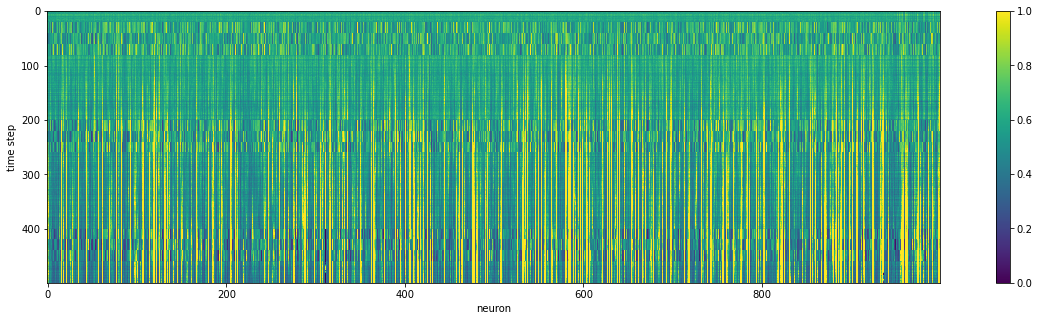

v_list = 


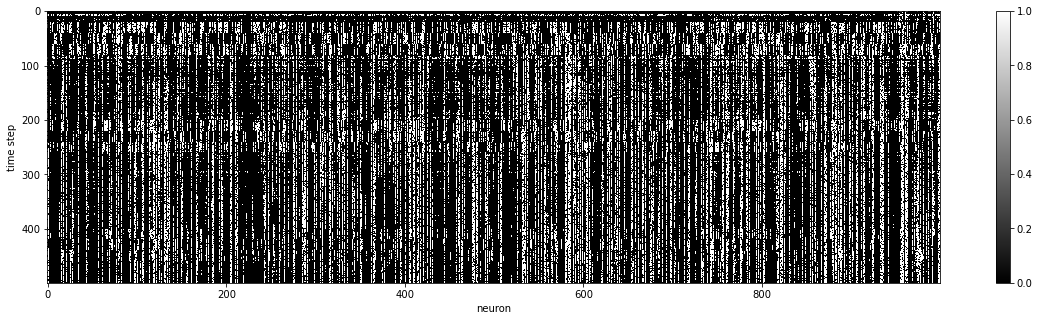

In [11]:
#Print activity matrices for viewing

print("neti_list = ")
neti_array = np.array(neti_list)
plt.figure(figsize=(20,5))
plt.matshow(neti_array[:,:],vmin = 0, vmax = 1, fignum=0,cmap="viridis",aspect="auto") #matshow() properly displays firing v_list without condensing and glitching
plt.ylabel('time step')
plt.xlabel('neuron')
plt.colorbar()
plt.gca().xaxis.tick_bottom() #moves x-axis to bottom of image
plt.show()

#Print activity matrix for viewing
print("v_list = ")
v_array = np.array(v_list)
plt.figure(figsize=(20,5))
plt.matshow(v_array[:,:],fignum=0,cmap="gray",aspect="auto") #matshow() properly displays firing v_list without condensing and glitching
plt.ylabel('time step')
plt.xlabel('neuron')
plt.colorbar()
plt.gca().xaxis.tick_bottom() #moves x-axis to bottom of image
plt.show()

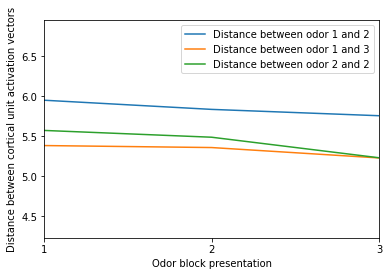

In [1117]:
#Scratch for calculating response to odor blocks
odor_dist = np.zeros((3,3));

resp11 = np.mean(v_array[20:40,:],axis=0)
resp12 = np.mean(v_array[40:60,:],axis=0)
resp13 = np.mean(v_array[60:80,:],axis=0)
odor_dist[0,0] = LA.norm(resp11-resp12)
odor_dist[0,1] = LA.norm(resp11-resp13)
odor_dist[0,2] = LA.norm(resp12-resp13)

resp21 = np.mean(v_array[200:220,:],axis=0)
resp22 = np.mean(v_array[220:240,:],axis=0)
resp23 = np.mean(v_array[240:260,:],axis=0)
odor_dist[1,0] = LA.norm(resp21-resp22)
odor_dist[1,1] = LA.norm(resp21-resp23)
odor_dist[1,2] = LA.norm(resp22-resp23)

resp31 = np.mean(v_array[400:420,:],axis=0)
resp32 = np.mean(v_array[420:440,:],axis=0)
resp33 = np.mean(v_array[440:460,:],axis=0)
odor_dist[2,0] = LA.norm(resp31-resp32)
odor_dist[2,1] = LA.norm(resp31-resp33)
odor_dist[2,2] = LA.norm(resp32-resp33)

"""
resp41 = np.mean(v_array[620:640,:],axis=0)
resp42 = np.mean(v_array[640:660,:],axis=0)
resp43 = np.mean(v_array[660:680,:],axis=0)
odor_dist[3,0] = LA.norm(resp41-resp42)
odor_dist[3,1] = LA.norm(resp41-resp43)
odor_dist[3,2] = LA.norm(resp42-resp43)

resp51 = np.mean(v_array[820:840,:],axis=0)
resp52 = np.mean(v_array[840:860,:],axis=0)
resp53 = np.mean(v_array[860:880,:],axis=0)
odor_dist[4,0] = LA.norm(resp51-resp52)
odor_dist[4,1] = LA.norm(resp51-resp53)
odor_dist[4,2] = LA.norm(resp52-resp53)
"""

x = [1,2,3]
plt.xticks(list(range(1,max(x)+1)),[str(i) for i in range(1,max(x)+1)])
plt.plot(x,odor_dist[:,0],label='Distance between odor 1 and 2')
plt.plot(x,odor_dist[:,1],label='Distance between odor 1 and 3')
plt.plot(x,odor_dist[:,2],label='Distance between odor 2 and 2')
xlim(1,len(x));
ylim(np.min(odor_dist)-1,np.max(odor_dist)+1);
plt.legend(loc="upper right")
plt.xlabel("Odor block presentation")
plt.ylabel("Distance between cortical unit activation vectors")
plt.show()


In [1047]:
#Script for ranking neurons with higher mean/total LOT/ASSN weights, and seeing if they coincide with the most active neurons in v_list

#Rank neurons with highest mean or total LOT inputs
LOT_mean = np.zeros((n,2))
LOT_mean[:,0] = range(n) #create a column for indexing the neurons
LOT_mean[:,1] = np.mean(M,axis=1).tolist() #take the mean of the rows (axis 0 is columns, 1 is rows)
LOT_mean = sorted(LOT_mean, key=lambda tup: tup[1], reverse=True) #sort by the second column (or the index 1 in the tuple, where each row is a tuple); this sorts by the value, not the index; reverse makes this descending sorting

LOT_total = np.zeros((n,2))
LOT_total[:,0] = range(n)
LOT_total[:,1] = np.sum(M,axis=1).tolist()
LOT_total = sorted(LOT_total, key=lambda tup: tup[1], reverse=True)

print("LOT total")
display(LOT_total[0:21])

#Rank neurons with highest mean or total ASSN inputs
ASSN_mean = np.zeros((n,2))
ASSN_mean[:,0] = range(n)
ASSN_mean[:,1] = np.mean(W,axis=1).tolist()
ASSN_mean = sorted(ASSN_mean, key=lambda tup: tup[1], reverse=True)

ASSN_total = np.zeros((n,2))
ASSN_total[:,0] = range(n)
ASSN_total[:,1] = np.sum(W,axis=1).tolist()
ASSN_total = sorted(ASSN_total, key=lambda tup: tup[1], reverse=True)

print("ASSN total")
display(ASSN_total[0:100:5])

#Rank neurons with highest mean or total ASSN inputs
ASSNnew_mean = np.zeros((n,2))
ASSNnew_mean[:,0] = range(n)
ASSNnew_mean[:,1] = np.mean(W_new,axis=1).tolist()
ASSNnew_mean = sorted(ASSNnew_mean, key=lambda tup: tup[1], reverse=True)

ASSNnew_total = np.zeros((n,2))
ASSNnew_total[:,0] = range(n)
ASSNnew_total[:,1] = np.sum(W_new,axis=1).tolist()
ASSNnew_total = sorted(ASSNnew_total, key=lambda tup: tup[1], reverse=True)

print("ASSN new total");
display(ASSNnew_total[0:21]);

"""
#Rank neurons in v_list with highest activity
v_mean = np.zeros((n,2))
v_mean[:,0] = range(n)
v_mean[:,1] = np.mean(v_list,axis=0).tolist()
v_mean = sorted(v_mean, key=lambda tup: tup[1], reverse=True)

v_total = np.zeros((n,2))
v_total[:,0] = range(n)
v_total[:,1] = np.sum(v_list,axis=0).tolist()
v_total = sorted(v_total, key=lambda tup: tup[1], reverse=True)

print("Most active neurons")
display(v_total[0:21])
"""


LOT total


[array([0., 1.]),
 array([4., 1.]),
 array([15.,  1.]),
 array([20.,  1.]),
 array([23.,  1.]),
 array([25.,  1.]),
 array([28.,  1.]),
 array([41.,  1.]),
 array([70.,  1.]),
 array([80.,  1.]),
 array([83.,  1.]),
 array([90.,  1.]),
 array([102.,   1.]),
 array([103.,   1.]),
 array([107.,   1.]),
 array([113.,   1.]),
 array([114.,   1.]),
 array([129.,   1.]),
 array([144.,   1.]),
 array([147.,   1.]),
 array([161.,   1.])]

ASSN total


[array([982.,   3.]),
 array([952.,   3.]),
 array([958.,   3.]),
 array([964.,   3.]),
 array([969.,   3.]),
 array([974.,   3.]),
 array([981.,   3.]),
 array([988.,   3.]),
 array([994.,   3.]),
 array([975.,   3.]),
 array([70.,  2.]),
 array([7., 2.]),
 array([61.,  2.]),
 array([105.,   2.]),
 array([132.,   2.]),
 array([167.,   2.]),
 array([209.,   2.]),
 array([235.,   2.]),
 array([293.,   2.]),
 array([341.,   2.])]

ASSN new total


[array([436.        ,  48.67732313]),
 array([767.        ,  27.88876841]),
 array([476.        ,  23.23861547]),
 array([338.        ,  20.84607769]),
 array([806.        ,  18.58370002]),
 array([406.        ,  18.55239346]),
 array([973.        ,  17.36606419]),
 array([324.        ,  17.28651082]),
 array([957.        ,  17.08907035]),
 array([960.        ,  17.00368539]),
 array([994.        ,  16.79693956]),
 array([170.        ,  15.51725252]),
 array([643.        ,  15.15970998]),
 array([81.        , 15.05678142]),
 array([514.        ,  14.95741058]),
 array([169.        ,  14.84882142]),
 array([480.        ,  14.54332399]),
 array([32.        , 14.29871889]),
 array([312.        ,  14.20648657]),
 array([650.        ,  14.19430577]),
 array([635.        ,  14.18958478])]

'\n#Rank neurons in v_list with highest activity\nv_mean = np.zeros((n,2))\nv_mean[:,0] = range(n)\nv_mean[:,1] = np.mean(v_list,axis=0).tolist()\nv_mean = sorted(v_mean, key=lambda tup: tup[1], reverse=True)\n\nv_total = np.zeros((n,2))\nv_total[:,0] = range(n)\nv_total[:,1] = np.sum(v_list,axis=0).tolist()\nv_total = sorted(v_total, key=lambda tup: tup[1], reverse=True)\n\nprint("Most active neurons")\ndisplay(v_total[0:21])\n'

In [1048]:
#Script for printing our pre-update and post-update metrics
"""
Note = now that the matrix is sparse, the symmetry index sucks, since many neurons don't send outputs to their input partners, so the reciprocity is very low
    - if we only look at matrices of inputs (W_nonzeros or something), then the matrix isn't square and the symmetry index is useless
"""

###############################################################################################
#Get pre-update metrics

#Make a new matrix that only shows the non-zero elements of W
W_pre_trunc = np.zeros((n,200));

for i in range(n):
    
    inputs = W[i,:];
    inputs = inputs[inputs != 0]; #find all non-zero elements in inputs to neuron i    
    W_pre_trunc[i,0:len(inputs)] = inputs;

#Visualize ASSN as heatmap (with heatmap anchored at weights of 0 and 1)
print("Pre-update heatmap")
ax = sns.heatmap(W_pre_trunc, vmin = -0.05, vmax = 0.05)
plt.show()

#Get rough estimate for symmetry of the pre-update matrix
#get the mean of the matrix - matrix^T (since symmetric matrix should have a mean of 0); np.absolute gets rid of negative values, so we have a positive index; this index is also normalized to mean(W), so differences don't just scale up with increasing weights after updating
pre_W_mean = mean(np.absolute(W - W.transpose()))/mean(np.absolute(W_pre_trunc)) #normalize by W_pre_trunc so we don't make the mean super tiny given most elements are 0
print("Pre-update W symmetry index = ", pre_W_mean)

###############################################################################################
#Get post-update metrics

#Make a new matrix that only shows the non-zero elements of W
W_post_trunc = np.zeros((n,200));

for i in range(n):
    
    inputs = W_new[i,:];
    inputs = inputs[inputs != 0]; #find all non-zero elements in inputs to neuron i
    W_post_trunc[i,0:len(inputs)] = inputs;

#Visualize ASSN as heatmap (with heatmap anchored at weights of 0 and 1)
print("Post-update ASSN weights")
ax = sns.heatmap(W_post_trunc, vmin = -0.05, vmax = 0.05);
plt.show();

#Get rough estimate for symmetry of the post-update matrix
#get the mean of the matrix - matrix^T (since symmetric matrix should have a mean of 0); np.absolute gets rid of negative values, so we have a positive index; this index is also normalized to mean(W), so differences don't just scale up with increasing weights after updating
post_W_mean = mean(np.absolute(W_new - W_new.transpose()))/mean(np.absolute(W_post_trunc))
print("Post-update W symmetry index = ", post_W_mean)

###############################################################################################
#Get difference between pre- and post-update weights, and visualize via heatmap
W_diff = W_post_trunc - W_pre_trunc

print("W_diff heatmap")
ax = sns.heatmap(W_diff, vmin = -0.05, vmax = 0.05);
plt.show();

print("Mean of W_diff = ", mean(W_diff)); #only consider elements that weren't 0 in the original weights matrix, since those weights won't have changed

ValueError: could not broadcast input array from shape (250,) into shape (200,)

Runaway modes =  1
Integrate modes =  13
Decay modes =  10
Runaway modes distances


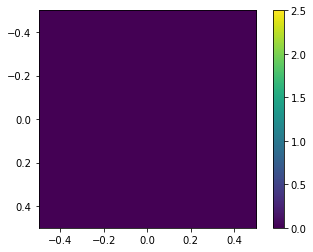

Integrate modes distances


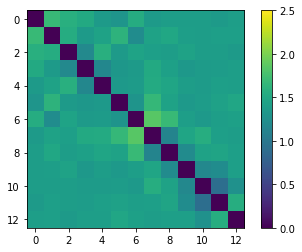

Decay modes distances


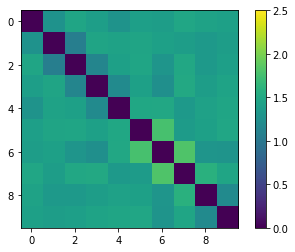

In [1118]:
#Eigenanalysis of pre-learning ASSN

w,v = LA.eig(W)
w = list(w)
evals = [];
evecs = [];
evecs_runaway = [];
evecs_integrate = [];
evecs_decay = [];

#Collect all real evals and evecs
for i in range(len(w)):
    
    Re = w[i].real
    Im = w[i].imag
    
    if Im == 0:
        
        evals.append(Re);
        evecs.append(v[:,i]);
        
        if Re < 0: #decay modes
            evecs_decay.append(v[:,i]);
        elif Re > 1: #runaway modes
            evecs_runaway.append(v[:,i]);
        else: #integrate nodes
            evecs_integrate.append(v[:,i]);
    
num_runaway_modes = len(evecs_runaway)
num_integrate_modes = len(evecs_integrate)
num_decay_modes = len(evecs_decay)

print("Runaway modes = ",num_runaway_modes)
print("Integrate modes = ",num_integrate_modes)
print("Decay modes = ",num_decay_modes)

evecs_runaway = np.transpose(array(evecs_runaway)) #transpose bc casting to array fucks up the axes of the appended list, such that the list columns become the array rows
evecs_integrate = np.transpose(array(evecs_integrate))
evecs_decay = np.transpose(array(evecs_decay))
    
#Calculate norms between runaway evecs
runaway_norms = np.zeros((num_runaway_modes,num_runaway_modes));

for i in range(num_runaway_modes):
    
    for j in range(num_runaway_modes):
        
        runaway_norms[i,j] = LA.norm(evecs_runaway[:,i]-evecs_runaway[:,j])

print("Runaway modes distances")
imshow(runaway_norms,vmin = 0, vmax = 2.5)
colorbar()
plt.show()
    
#Calculate norms between runaway evecs
integrate_norms = np.zeros((num_integrate_modes,num_integrate_modes));

for i in range(num_integrate_modes):
    
    for j in range(num_integrate_modes):
        
        integrate_norms[i,j] = LA.norm(evecs_integrate[:,i]-evecs_integrate[:,j])

print("Integrate modes distances")
imshow(integrate_norms, vmin = 0, vmax = 2.5)
colorbar()
plt.show()

#Calculate norms between runaway evecs
decay_norms = np.zeros((num_decay_modes,num_decay_modes));

for i in range(num_decay_modes):
    
    for j in range(num_decay_modes):
        
        decay_norms[i,j] = LA.norm(evecs_decay[:,i]-evecs_decay[:,j]);

print("Decay modes distances")
imshow(decay_norms, vmin = 0, vmax = 2.5)
colorbar()
plt.show()

Runaway modes =  1
Integrate modes =  14
Decay modes =  13
Runaway modes distances


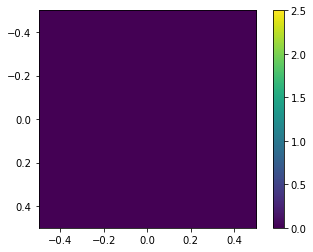

Integrate modes distances


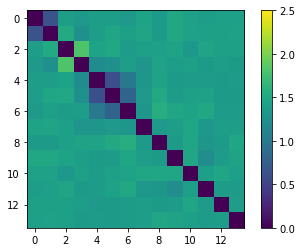

Decay modes distances


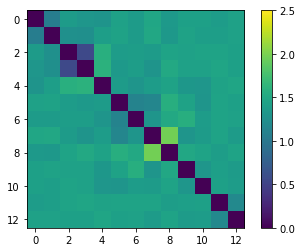

In [1119]:
#Eigenanalysis of post-learning ASSN
w,v = LA.eig(W_new)
w = list(w)
evals = [];
evecs = [];
evecs_runaway = [];
evecs_integrate = [];
evecs_decay = [];

#Collect all real evals and evecs
for i in range(len(w)):
    
    Re = w[i].real
    Im = w[i].imag
    
    if Im == 0:
        
        evals.append(Re);
        evecs.append(v[:,i]);
        
        if Re < 0: #decay modes
            evecs_decay.append(v[:,i]);
        elif Re > 1: #runaway modes
            evecs_runaway.append(v[:,i]);
        else: #integrate nodes
            evecs_integrate.append(v[:,i]);
    
num_runaway_modes = len(evecs_runaway)
num_integrate_modes = len(evecs_integrate)
num_decay_modes = len(evecs_decay)

print("Runaway modes = ",num_runaway_modes)
print("Integrate modes = ",num_integrate_modes)
print("Decay modes = ",num_decay_modes)

evecs_runaway = np.transpose(array(evecs_runaway)) #transpose bc casting to array fucks up the axes of the appended list, such that the list columns become the array rows
evecs_integrate = np.transpose(array(evecs_integrate))
evecs_decay = np.transpose(array(evecs_decay))
    
#Calculate norms between runaway evecs
runaway_norms = np.zeros((num_runaway_modes,num_runaway_modes));

for i in range(num_runaway_modes):
    
    for j in range(num_runaway_modes):
        
        runaway_norms[i,j] = LA.norm(evecs_runaway[:,i]-evecs_runaway[:,j])

print("Runaway modes distances")
imshow(runaway_norms,vmin = 0, vmax = 2.5)
colorbar()
plt.show()
    
#Calculate norms between runaway evecs
integrate_norms = np.zeros((num_integrate_modes,num_integrate_modes));

for i in range(num_integrate_modes):
    
    for j in range(num_integrate_modes):
        
        integrate_norms[i,j] = LA.norm(evecs_integrate[:,i]-evecs_integrate[:,j])

print("Integrate modes distances")
imshow(integrate_norms, vmin = 0, vmax = 2.5)
colorbar()
plt.show()

#Calculate norms between runaway evecs
decay_norms = np.zeros((num_decay_modes,num_decay_modes));

for i in range(num_decay_modes):
    
    for j in range(num_decay_modes):
        
        decay_norms[i,j] = LA.norm(evecs_decay[:,i]-evecs_decay[:,j]);

print("Decay modes distances")
imshow(decay_norms, vmin = 0, vmax = 2.5)
colorbar()
plt.show()

LOT not LTPing, so ASSN still continues to dominate even if LOT survives for a little bit;

Try larger population with even sparser connectivity? try actual numbers (500k neurons, 200 LOT and 2000 ASSN)

Distances are quite small given we are in 1000D